A corriger dans le process etl
- format datime : soit formart UTC soit format ns
- renommer les deux colonnes en df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

In [237]:
import pandas as pd
import requests
import json
import os
import io
from dotenv import load_dotenv
import logging
from sqlalchemy import create_engine, text
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

load_dotenv()

True

In [238]:
db_url = os.getenv("DATABASE_URL")

In [239]:
engine = create_engine(
    db_url,
    pool_pre_ping=True,
)

with engine.connect() as conn:
    #result_transport = conn.execute(text("SELECT * FROM stg_transport_archive"))
    #transport_data = result_transport.mappings().all()  # liste de dictionnaires

    result_weather = conn.execute(text("SELECT * FROM stg_weather_archive"))
    weather_data = result_weather.mappings().all()  # liste de dictionnaires

    

In [240]:
BASE_DIR = os.getcwd() 

DATA_DIR = os.path.join(BASE_DIR, "..","data")
json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_3_days.json")
#json_path = os.path.join(DATA_DIR, "transport_koda_one_bus_any_days.json")

if not os.path.exists(json_path):
    print(f"Dossier actuel de recherche : {BASE_DIR}")
    raise FileNotFoundError(f"Le fichier {json_path} est introuvable.")

with open(json_path, 'r', encoding='utf-8') as f:
    transport_data = json.load(f)

In [241]:
df_transport = pd.DataFrame(transport_data)
df_transport.describe()

,timestamp,stop_sequence,arrival_delay,departure_delay,hour
count,9.210000e+03,9210.000000,9210.000000,9210.000000,9210.000000
mean,1.742126e+09,18.517698,70.618132,80.862215,12.633659
std,7.518701e+04,10.384672,130.953972,127.313354,6.506927
min,1.741900e+09,1.000000,-491.000000,-489.000000,0.000000
25%,1.742059e+09,10.000000,0.000000,0.000000,8.000000
50%,1.742127e+09,19.000000,56.000000,62.000000,13.000000
75%,1.742195e+09,28.000000,142.000000,149.000000,18.000000
max,1.742252e+09,36.000000,2292.000000,2292.000000,23.000000


In [242]:
df_weather = pd.DataFrame(weather_data)
df_weather.sample(20)

,cloud_cover,day_of_week,dew_point_2m,est_jour_ferie,est_weekend,month,neige_fondue,precipitation,rain,risque_gel_neige,...,soleil_leve,temperature_2m,timestamp_rounded,uv_index,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m,year
25558,100,6,5.6,1,1,11,0,1.2,1.2,0,...,0,5.9,2025-11-30 22:00:00,None,0,55,184,28.8,13.9,2025
19828,100,6,-6.7,1,1,4,0,0.0,0.0,0,...,0,-0.6,2025-04-06 04:00:00,None,0,3,253,11.9,5.6,2025
25644,100,3,3.2,0,0,12,0,0.0,0.0,0,...,1,4.3,2025-12-04 12:00:00,None,0,3,170,13.0,7.0,2025
25324,100,4,-1.9,0,0,11,0,0.0,0.0,0,...,0,0.8,2025-11-21 04:00:00,None,0,3,354,44.6,21.2,2025
10865,100,3,3.0,0,0,3,0,0.1,0.1,0,...,1,6.8,2024-03-28 17:00:00,None,0,51,93,25.2,12.3,2024
22920,100,2,13.4,0,0,8,0,0.0,0.0,0,...,0,15.2,2025-08-13 00:00:00,None,1,3,146,10.8,4.8,2025
16815,100,6,5.6,1,1,12,0,0.0,0.0,0,...,0,6.8,2024-12-01 15:00:00,None,0,3,221,32.4,15.8,2024
17481,100,6,3.9,1,1,12,0,0.0,0.0,0,...,1,5.7,2024-12-29 09:00:00,None,1,3,241,44.3,20.9,2024
25486,100,3,1.8,0,0,11,0,0.0,0.0,0,...,0,2.5,2025-11-27 22:00:00,None,0,3,205,37.8,19.5,2025
16879,0,2,-8.9,0,0,12,0,0.0,0.0,0,...,0,-8.0,2024-12-04 07:00:00,None,0,0,23,9.7,3.7,2024


In [243]:
df_transport = pd.DataFrame(transport_data)

df_transport = df_transport.rename(columns={'datetime_rounded': 'timestamp_rounded'})

# Pour vérifier
print(df_transport.columns)
df_transport.describe(include='all')

Index(['timestamp', 'direction_id', 'stop_sequence', 'arrival_delay',
       'departure_delay', 'timestamp_rounded', 'hour', 'bus_nbr'],
      dtype='object')


,timestamp,direction_id,stop_sequence,arrival_delay,departure_delay,timestamp_rounded,hour,bus_nbr
count,9.210000e+03,9210,9210.000000,9210.000000,9210.000000,9210,9210.000000,9210
unique,NaN,2,NaN,NaN,NaN,69,NaN,1
top,NaN,1,NaN,NaN,NaN,2025-03-16T23:00:00+00:00,NaN,541
freq,NaN,4682,NaN,NaN,NaN,145,NaN,9210
mean,1.742126e+09,NaN,18.517698,70.618132,80.862215,NaN,12.633659,NaN
std,7.518701e+04,NaN,10.384672,130.953972,127.313354,NaN,6.506927,NaN
min,1.741900e+09,NaN,1.000000,-491.000000,-489.000000,NaN,0.000000,NaN
25%,1.742059e+09,NaN,10.000000,0.000000,0.000000,NaN,8.000000,NaN
50%,1.742127e+09,NaN,19.000000,56.000000,62.000000,NaN,13.000000,NaN
75%,1.742195e+09,NaN,28.000000,142.000000,149.000000,NaN,18.000000,NaN


In [244]:
# 1. Convertir en datetime ET forcer l'UTC pour les deux --> à corriger dans le process etl /!\
df_transport['timestamp_rounded'] = pd.to_datetime(df_transport['timestamp_rounded'], utc=True)
df_weather['timestamp_rounded'] = pd.to_datetime(df_weather['timestamp_rounded'], utc=True)

# 2. Maintenant le merge fonctionnera sans erreur
df_merged = pd.merge(
    df_transport,
    df_weather,
    on="timestamp_rounded",
    how="left"
)

# 3. Suppression des colonnes
cols_to_drop = ["entity_id", "route_id_static", "timestamp", "timestamp_dt", 
                "trip_id", "route_id", "year", "uv_index", "shortwave_radiation"]

df_merged = df_merged.drop(columns=cols_to_drop, errors='ignore')

df_merged.sample(20)

,direction_id,stop_sequence,arrival_delay,departure_delay,timestamp_rounded,hour,bus_nbr,cloud_cover,day_of_week,dew_point_2m,...,risque_gel_neige,risque_gel_pluie,snowfall,soleil_leve,temperature_2m,vacances_scolaires,weather_code,wind_direction_10m,wind_gusts_10m,wind_speed_10m
1316,0,21,157,200,2025-03-15 15:00:00+00:00,15,541,65,5,-5.3,...,0,0,0.00,1,5.8,0,2,257,48.6,21.4
2138,0,7,0,0,2025-03-15 15:00:00+00:00,15,541,65,5,-5.3,...,0,0,0.00,1,5.8,0,2,257,48.6,21.4
5866,1,7,25,25,2025-03-16 00:00:00+00:00,0,541,100,6,-2.8,...,0,0,0.00,0,1.4,0,3,260,38.5,18.3
8584,0,22,176,182,2025-03-17 20:00:00+00:00,20,541,100,0,-5.3,...,0,0,0.00,0,2.7,0,3,267,41.4,19.8
5057,0,10,321,321,2025-03-16 12:00:00+00:00,12,541,45,6,-11.1,...,0,0,0.00,1,3.5,0,1,330,50.4,22.9
6049,0,2,90,90,2025-03-16 01:00:00+00:00,1,541,97,6,-2.4,...,0,0,0.00,0,1.3,0,3,264,38.5,17.6
6711,1,32,235,247,2025-03-17 18:00:00+00:00,18,541,100,0,-5.3,...,0,0,0.07,0,2.2,0,71,267,42.5,19.3
2431,0,15,109,110,2025-03-15 05:00:00+00:00,5,541,0,5,-7.2,...,0,0,0.00,0,-2.1,0,0,242,19.8,10.0
6540,0,3,131,131,2025-03-17 17:00:00+00:00,17,541,100,0,-6.5,...,0,0,0.00,1,3.0,0,3,273,47.2,19.8
1331,1,29,55,90,2025-03-15 12:00:00+00:00,12,541,94,5,-10.4,...,0,0,0.00,1,5.8,0,3,241,44.6,19.8


In [245]:
df_merged.columns

Index(['direction_id', 'stop_sequence', 'arrival_delay', 'departure_delay',
       'timestamp_rounded', 'hour', 'bus_nbr', 'cloud_cover', 'day_of_week',
       'dew_point_2m', 'est_jour_ferie', 'est_weekend', 'month',
       'neige_fondue', 'precipitation', 'rain', 'risque_gel_neige',
       'risque_gel_pluie', 'snowfall', 'soleil_leve', 'temperature_2m',
       'vacances_scolaires', 'weather_code', 'wind_direction_10m',
       'wind_gusts_10m', 'wind_speed_10m'],
      dtype='object')

# EDA

In [246]:
# ====================
# 1. CHARGEMENT ET NETTOYAGE
# ====================

# Filtrer les données avec transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print("="*20)
print("EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE")
print("="*20)
print(f"\nNombre total d'observations : {len(df):,}")
print(f"Période couverte : {df['timestamp_rounded'].min()} à {df['timestamp_rounded'].max()}")
print(f"Nombre de jours : {df['timestamp_rounded'].dt.date.nunique()}")

EXPLORATION DES DONNÉES - JUSTIFICATION MÉTHODOLOGIQUE

Nombre total d'observations : 9,210
Période couverte : 2025-03-13 21:00:00+00:00 à 2025-03-17 23:00:00+00:00
Nombre de jours : 5



1. DISTRIBUTION DES RETARDS

Statistiques des retards (en secondes) :
count    9210.000000
mean       80.862215
std       127.313354
min      -489.000000
25%         0.000000
50%        62.000000
75%       149.000000
max      2292.000000
Name: departure_delay, dtype: float64

Médiane : 62.0s
Mode : 0.0s

Répartition par tranches de retard :
delay_category
Avance      2584
0-1 min     1941
1-2 min     1712
2-5 min     2468
5-10 min     496
>10 min        9
Name: count, dtype: int64

En pourcentage :
delay_category
Avance      28.1
0-1 min     21.1
1-2 min     18.6
2-5 min     26.8
5-10 min     5.4
>10 min      0.1
Name: proportion, dtype: float64


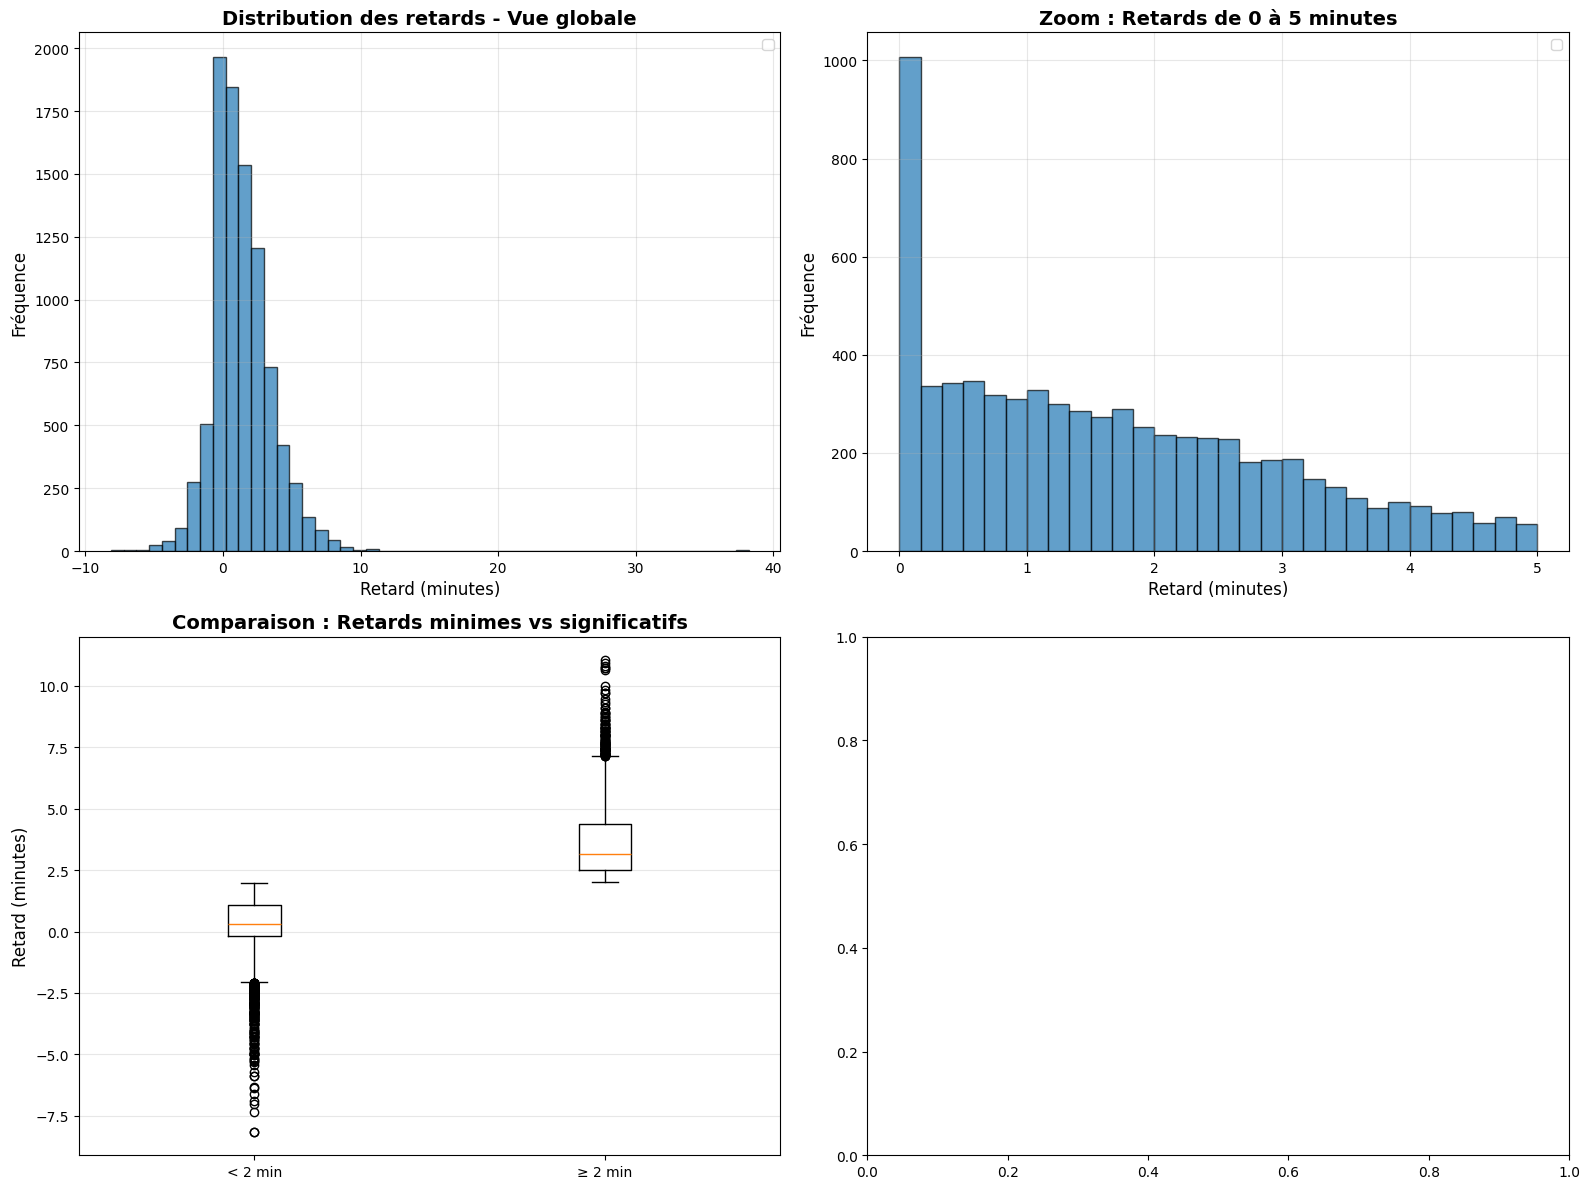

In [247]:
# ====================
# 2. DISTRIBUTION DES RETARDS - ARGUMENT CLÉ
# ====================

print("\n" + "="*20)
print("1. DISTRIBUTION DES RETARDS")
print("="*20)

# Statistiques descriptives
print("\nStatistiques des retards (en secondes) :")
print(df['departure_delay'].describe())
print(f"\nMédiane : {df['departure_delay'].median():.1f}s")
print(f"Mode : {df['departure_delay'].mode().values[0]:.1f}s")

# Conversion en minutes pour lisibilité
df['delay_minutes'] = df['departure_delay'] / 60

# Distribution détaillée par tranches
print("\nRépartition par tranches de retard :")
bins = [-500, 0, 60, 120, 300, 600, 3000]
labels = ['Avance', '0-1 min', '1-2 min', '2-5 min', '5-10 min', '>10 min']
df['delay_category'] = pd.cut(df['departure_delay'], bins=bins, labels=labels)
print(df['delay_category'].value_counts().sort_index())
print("\nEn pourcentage :")
print((df['delay_category'].value_counts(normalize=True)*100).sort_index().round(1))

# GRAPHIQUE 1 : Distribution bimodale
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogramme global
axes[0, 0].hist(df['delay_minutes'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 0].set_ylabel('Fréquence', fontsize=12)
axes[0, 0].set_title('Distribution des retards - Vue globale', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Focus sur les petits retards (0-5 min)
mask_small = (df['delay_minutes'] >= 0) & (df['delay_minutes'] <= 5)
axes[0, 1].hist(df.loc[mask_small, 'delay_minutes'], bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Retard (minutes)', fontsize=12)
axes[0, 1].set_ylabel('Fréquence', fontsize=12)
axes[0, 1].set_title('Zoom : Retards de 0 à 5 minutes', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Boxplot par catégories
df_boxplot = df[df['delay_minutes'] <= 20]  # Limiter pour visibilité
axes[1, 0].boxplot([df_boxplot[df_boxplot['delay_minutes'] < 2]['delay_minutes'],
                     df_boxplot[df_boxplot['delay_minutes'] >= 2]['delay_minutes']],
                    labels=['< 2 min', '≥ 2 min'])
axes[1, 0].set_ylabel('Retard (minutes)', fontsize=12)
axes[1, 0].set_title('Comparaison : Retards minimes vs significatifs', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

plt.tight_layout()

On pourrait considérer 2 populations :
- retards minimes vs significatifs
- 68 % des cas, moins de 2 min de rtards (quasi à l'heure)
- 32 % avec plus de 2 min de retards (retards réel)


3. CORRÉLATIONS DIFFÉRENTES SELON LE GROUPE

 Corrélations avec departure_delay :
                Sans_retard_significatif  Avec_retard_significatif  Différence
temperature_2m                     0.028                     0.138       0.110
precipitation                      0.014                     0.030       0.016
wind_speed_10m                     0.011                     0.085       0.074
cloud_cover                        0.003                     0.094       0.091
stop_sequence                     -0.357                     0.118       0.475
hour                               0.041                     0.013      -0.028


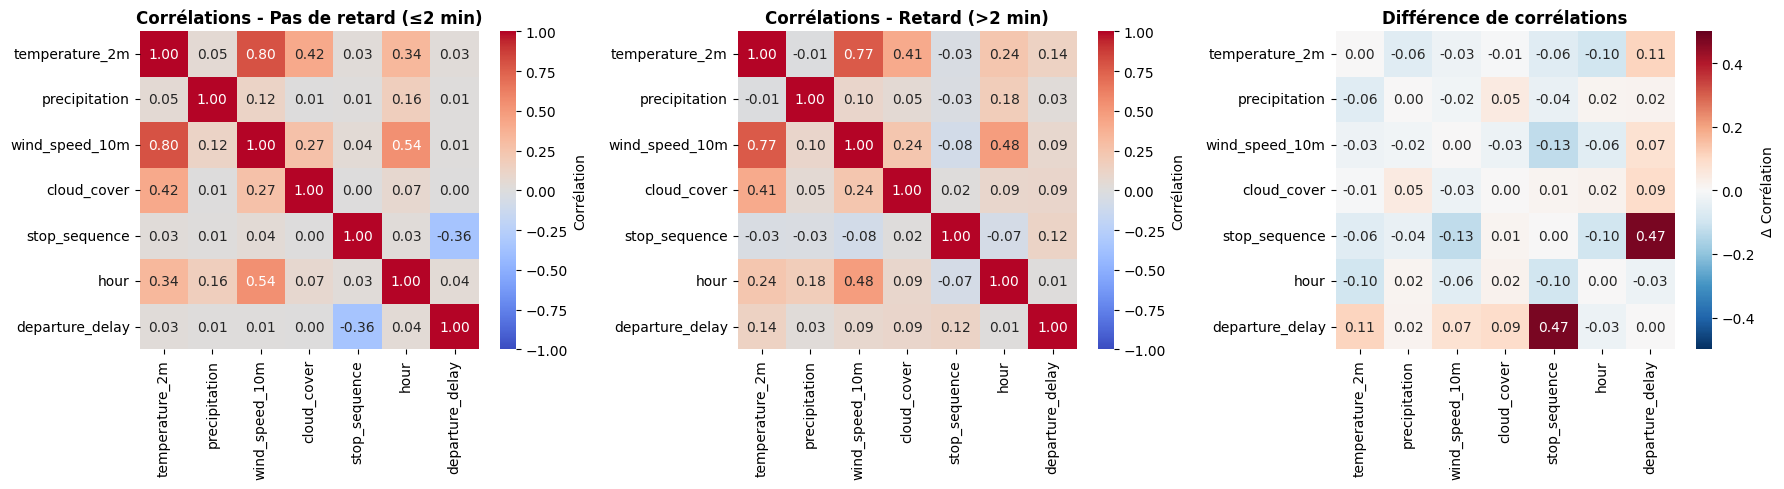

In [248]:
# ============================================================================
# 3. CORRÉLATIONS CONDITIONNELLES
# ============================================================================

print("\n" + "="*20)
print("3. CORRÉLATIONS DIFFÉRENTES SELON LE GROUPE")
print("="*20)

SEUIL = 120  # 2 minutes
df['has_delay'] = (df['departure_delay'] > SEUIL).astype(int)

# Calculer corrélations pour chaque groupe
numeric_cols = ['temperature_2m', 'precipitation', 'wind_speed_10m', 
                'cloud_cover', 'stop_sequence', 'hour']

df_no_delay = df[df['has_delay']==0][numeric_cols + ['departure_delay']].copy()
df_delay = df[df['has_delay']==1][numeric_cols + ['departure_delay']].copy()

corr_no_delay = df_no_delay.corr()['departure_delay'].drop('departure_delay')
corr_delay = df_delay.corr()['departure_delay'].drop('departure_delay')

print("\n Corrélations avec departure_delay :")
corr_comparison = pd.DataFrame({
    'Sans_retard_significatif': corr_no_delay,
    'Avec_retard_significatif': corr_delay,
    'Différence': corr_delay - corr_no_delay
})
print(corr_comparison.round(3))

# GRAPHIQUE 3 : Heatmap comparative
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sans retard
sns.heatmap(df_no_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Corrélation'})
axes[0].set_title('Corrélations - Pas de retard (≤2 min)', fontsize=12, fontweight='bold')

# Avec retard
sns.heatmap(df_delay.corr(), annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Corrélation'})
axes[1].set_title('Corrélations - Retard (>2 min)', fontsize=12, fontweight='bold')

# Différence
diff_matrix = df_delay.corr() - df_no_delay.corr()
sns.heatmap(diff_matrix, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, vmin=-0.5, vmax=0.5, ax=axes[2], cbar_kws={'label': 'Δ Corrélation'})
axes[2].set_title('Différence de corrélations', fontsize=12, fontweight='bold')

plt.tight_layout()

Facteurs explicatifs différents
* Les corrélations changent selon le groupe retards +/- 2 min



4. PATTERNS TEMPORELS - Justification de features temporelles

Retards par heure de la journée :
    hour  prob_retard  retard_moyen
0      0         0.34         60.40
1      1         0.24         59.22
2      2         1.00       2292.00
3      4         0.06         37.42
4      5         0.20         43.13
5      6         0.14         34.80
6      7         0.31         70.29
7      8         0.34         86.20
8      9         0.28         83.09
9     10         0.18         42.94
10    11         0.39         95.76
11    12         0.44        116.62
12    13         0.43        106.39
13    14         0.36         92.04
14    15         0.43        113.47
15    16         0.42        104.35
16    17         0.36         90.70
17    18         0.38         99.87
18    19         0.38        103.41
19    20         0.38         85.94
20    21         0.36         84.47
21    22         0.28         72.52
22    23         0.27         63.62


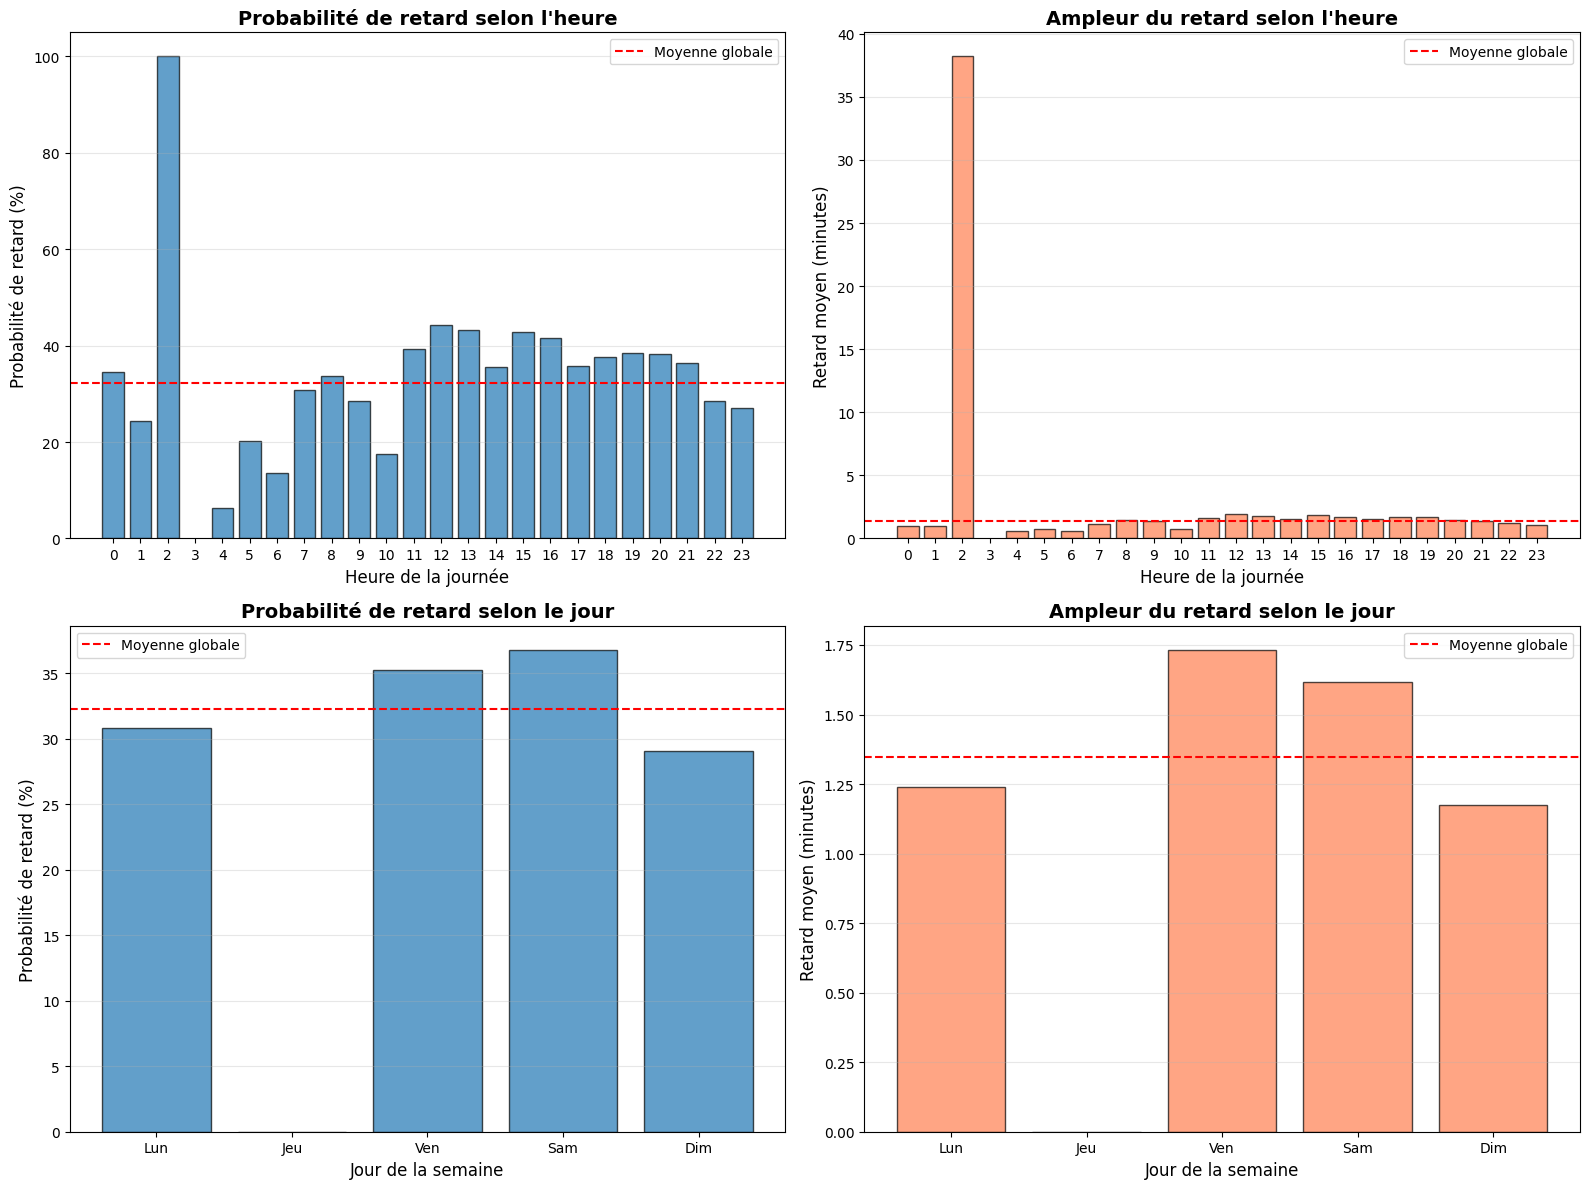

In [249]:
# =====================
# 5. PATTERNS TEMPORELS
# =====================

print("\n" + "="*20)
print("4. PATTERNS TEMPORELS - Justification de features temporelles")
print("="*20)

# Par heure
delay_by_hour = df.groupby('hour').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_hour.columns = ['hour', 'prob_retard', 'retard_moyen']

print("\nRetards par heure de la journée :")
print(delay_by_hour.round(2))

# Par jour de la semaine
delay_by_dow = df.groupby('day_of_week').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()
delay_by_dow.columns = ['day_of_week', 'prob_retard', 'retard_moyen']
delay_by_dow['day_name'] = delay_by_dow['day_of_week'].map({
    0: 'Lun', 1: 'Mar', 2: 'Mer', 3: 'Jeu', 4: 'Ven', 5: 'Sam', 6: 'Dim'
})

# GRAPHIQUE 4 : Patterns temporels
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1- Probabilité de retard par heure
axes[0, 0].bar(delay_by_hour['hour'], delay_by_hour['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[0, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 0].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0, 0].set_title('Probabilité de retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].set_xticks(range(24))

# 2- Ampleur moyenne par heure
axes[0, 1].bar(delay_by_hour['hour'], delay_by_hour['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[0, 1].set_xlabel('Heure de la journée', fontsize=12)
axes[0, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[0, 1].set_title('Ampleur du retard selon l\'heure', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_xticks(range(24))

# 3- Par jour de la semaine - Probabilité
axes[1, 0].bar(delay_by_dow['day_name'], delay_by_dow['prob_retard']*100, 
               edgecolor='black', alpha=0.7)
axes[1, 0].axhline(df['has_delay'].mean()*100, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 0].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[1, 0].set_title('Probabilité de retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4- Par jour de la semaine - Ampleur
axes[1, 1].bar(delay_by_dow['day_name'], delay_by_dow['retard_moyen']/60, 
               color='coral', edgecolor='black', alpha=0.7)
axes[1, 1].axhline(df['departure_delay'].mean()/60, color='red', linestyle='--', 
                   label='Moyenne globale')
axes[1, 1].set_xlabel('Jour de la semaine', fontsize=12)
axes[1, 1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1, 1].set_title('Ampleur du retard selon le jour', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()


5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non

 Retards selon les conditions météo :
              Nombre  Prob_retard  Retard_moyen_sec  Retard_moyen_min
weather_code                                                         
Ciel clair      2587         0.27             64.31          1.071833
Neige            720         0.38            101.65          1.694167
Nuageux         5903         0.34             85.58          1.426333


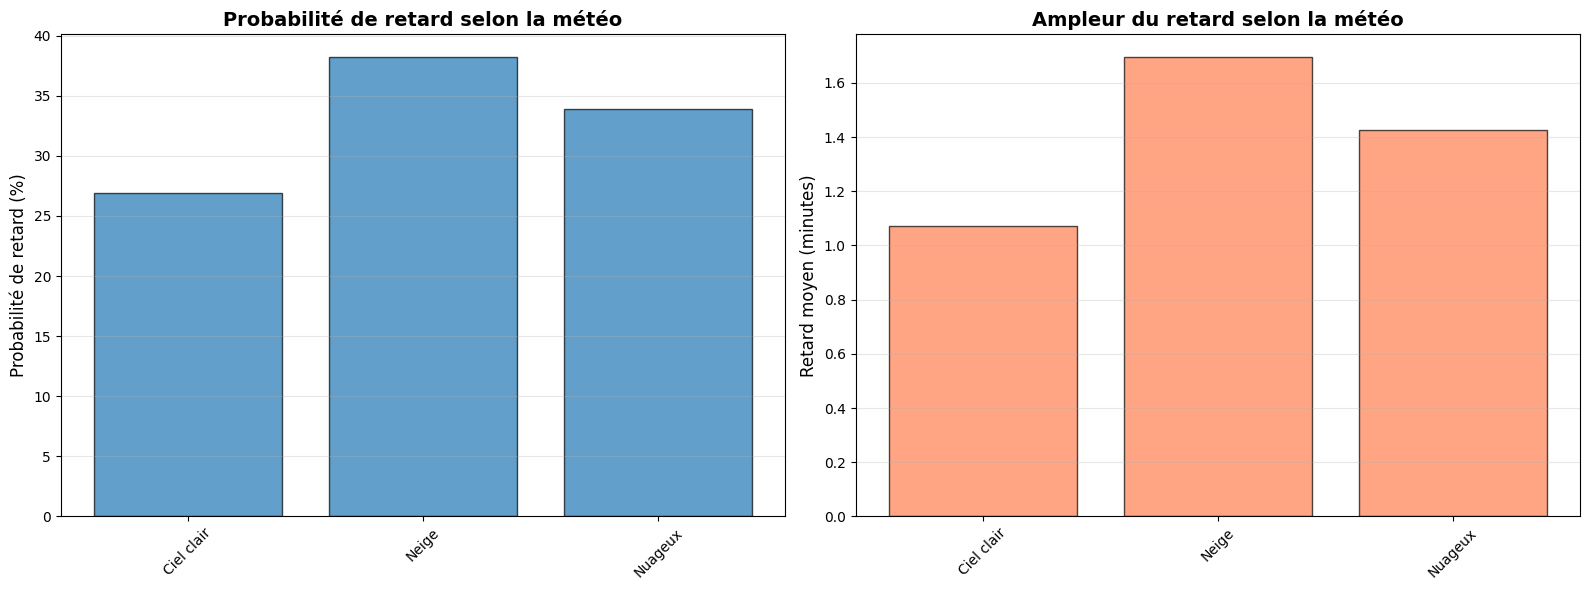

In [250]:
# ========================================
# 6. IMPACT MÉTÉO - VISION CONDITIONNELLE
# =======================================

print("\n" + "="*20)
print("5. IMPACT MÉTÉO - Différent selon qu'il y a retard ou non")
print("="*20)

# Catégoriser la météo
df.loc[df['weather_code'].isin([61, 63, 65]), 'weather_code'] = 'Pluie'
df.loc[df['weather_code'].isin([71, 73, 75]), 'weather_code'] = 'Neige'
df.loc[df['weather_code'].isin([51, 53, 55]), 'weather_code'] = 'Bruine'
df.loc[df['weather_code'].isin([1, 2, 3]), 'weather_code'] = 'Nuageux'
df.loc[df['weather_code'].isin([0]), 'weather_code'] = 'Ciel clair'

print("\n Retards selon les conditions météo :")
meteo_impact = df.groupby('weather_code').agg({
    'has_delay': ['count', 'mean'],
    'departure_delay': 'mean'
}).round(2)

meteo_impact.columns = ['Nombre', 'Prob_retard', 'Retard_moyen_sec']
meteo_impact['Retard_moyen_min'] = meteo_impact['Retard_moyen_sec'] / 60
print(meteo_impact)

# GRAPHIQUE 5 : Impact météo
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

meteo_stats = df.groupby('weather_code').agg({
    'has_delay': 'mean',
    'departure_delay': 'mean'
}).reset_index()

axes[0].bar(meteo_stats['weather_code'], meteo_stats['has_delay']*100, 
            edgecolor='black', alpha=0.7)
axes[0].set_ylabel('Probabilité de retard (%)', fontsize=12)
axes[0].set_title('Probabilité de retard selon la météo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(meteo_stats['weather_code'], meteo_stats['departure_delay']/60, 
            color='coral', edgecolor='black', alpha=0.7)
axes[1].set_ylabel('Retard moyen (minutes)', fontsize=12)
axes[1].set_title('Ampleur du retard selon la météo', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()

In [251]:
# Statistiques finales
print("\n Statistiques finales :")
print(f"  Nombre total d'observations : {len(df):}")
print(f"  Retard moyen global : {df['departure_delay'].mean()/60:.2f} minutes")
print(f"  Retard moyen si retard >2 min : {df[df['has_delay']==1]['departure_delay'].mean()/60:.2f} minutes")
print(f"  Écart-type global : {df['departure_delay'].std()/60:.2f} minutes")
print(f"  Écart-type si retard >2 min : {df[df['has_delay']==1]['departure_delay'].std()/60:.2f} minutes")

print("\n" + "="*20)
print("EXPLORATION TERMINÉE")
print("="*20)


 Statistiques finales :
  Nombre total d'observations : 9210
  Retard moyen global : 1.35 minutes
  Retard moyen si retard >2 min : 3.67 minutes
  Écart-type global : 2.12 minutes
  Écart-type si retard >2 min : 1.73 minutes

EXPLORATION TERMINÉE


## Synthèse 

On pourrait considérer 2 populations :
- retards minimes vs significatifs
- 68 % des cas, moins de 2 min de rtards (quasi à l'heure)
- 32 % avec plus de 2 min de retards (retards réel)

Facteurs explicatifs différents
* Les corrélations changent selon le groupe retards +/- 2 min
* Probabilité de retard vs ampleur du retard différentes

Objectifs différents
* 1/ doit je prévenir l'usager d'un retard ? --> 0/1
* 2/ de combien sera le retard ? --> indication précise
--> prédire 2 min quand il n'y a pas de retard == est-ce utile ??

L'idée
- 1 modèle unique = risque de mélanger deux phénomènes différents
- Regression seule = force à prédire des micro-variations non pertinentes
- deux modèles optimisés : chacun sa tâche

--> Etape 1 : Classfier (retard oui/non avec seuil à 2min)
--> Etape 2 : Si retard prédit, estimer l'ampleur (régression sur uniquement les cas de retards)

# ML

In [252]:
# ====================
# PRÉPARATION DES DONNÉES
# ====================
# Filtrer uniquement les lignes où on a des données de transport
df = df_merged[df_merged['departure_delay'].notna()].copy()

print(f"Nombre total d'observations : {len(df)}")
print(f"Retards > 2 min : {(df['departure_delay'] > 120).sum()} ({(df['departure_delay'] > 120).mean()*100:.1f}%)")



Nombre total d'observations : 9210
Retards > 2 min : 2973 (32.3%)


In [253]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9210 entries, 0 to 9209
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   direction_id        9210 non-null   object             
 1   stop_sequence       9210 non-null   int64              
 2   arrival_delay       9210 non-null   int64              
 3   departure_delay     9210 non-null   int64              
 4   timestamp_rounded   9210 non-null   datetime64[ns, UTC]
 5   hour                9210 non-null   int64              
 6   bus_nbr             9210 non-null   object             
 7   cloud_cover         9210 non-null   int64              
 8   day_of_week         9210 non-null   int64              
 9   dew_point_2m        9210 non-null   float64            
 10  est_jour_ferie      9210 non-null   int64              
 11  est_weekend         9210 non-null   int64              
 12  month               9210 non-null 

In [254]:
# ====================
# FEATURE ENGINEERING
# ====================

# Définir le seuil de retard (2 minutes = 120 secondes)
SEUIL_RETARD = 120
df['is_delayed'] = (df['departure_delay'] > SEUIL_RETARD).astype(int)

# Features temporelles additionnelles
df['is_rush_hour'] = df['hour'].isin([7, 8, 9, 17, 18, 19]).astype(int)

# Sélection des features
feature_cols = [
    # Transport
    'direction_id', 'stop_sequence', 'hour', 
    # Temporel
    'day_of_week', 'est_weekend', 'est_jour_ferie', 'vacances_scolaires',
    'is_rush_hour', 'soleil_leve', 'month',
    # Météo brute
    'temperature_2m', 'precipitation', 'wind_speed_10m', 'cloud_cover',
    'snowfall', 'rain', 'weather_code', 'dew_point_2m', 'wind_direction_10m', 'wind_gusts_10m',
    # Risques
    'risque_gel_neige', 'risque_gel_pluie', 'neige_fondue'
]

# Garder seulement les colonnes existantes
feature_cols = [col for col in feature_cols if col in df.columns]

# Séparer features numériques et catégorielles
numeric_features = df[feature_cols].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\nFeatures numériques : {len(numeric_features)}")
print(f"Features catégorielles : {len(categorical_features)}")


Features numériques : 21
Features catégorielles : 1


In [255]:
# ====================
# PRÉPARATION X ET Y
# ====================

X = df[feature_cols].copy()
y_classification = df['is_delayed']
y_regression = df['departure_delay']

# Split train/test
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_classification, test_size=0.2, random_state=42, stratify=y_classification
)

_, _, y_reg_train, y_reg_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42, stratify=y_classification
)

# ====================
# PIPELINE DE PRÉTRAITEMENT
# ====================

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
    ],
    remainder='drop'
)


MODÈLE 1 : CLASSIFICATION - Détection de retard > 2 minutes

Entraînement Logistic Regression...
Entraînement Random Forest...

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.76      0.58      0.66      1247
           1       0.41      0.62      0.50       595

    accuracy                           0.59      1842
   macro avg       0.59      0.60      0.58      1842
weighted avg       0.65      0.59      0.61      1842

ROC-AUC : 0.627

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.85      0.72      0.78      1247
           1       0.55      0.73      0.63       595

    accuracy                           0.72      1842
   macro avg       0.70      0.72      0.70      1842
weighted avg       0.75      0.72      0.73      1842

ROC-AUC : 0.808


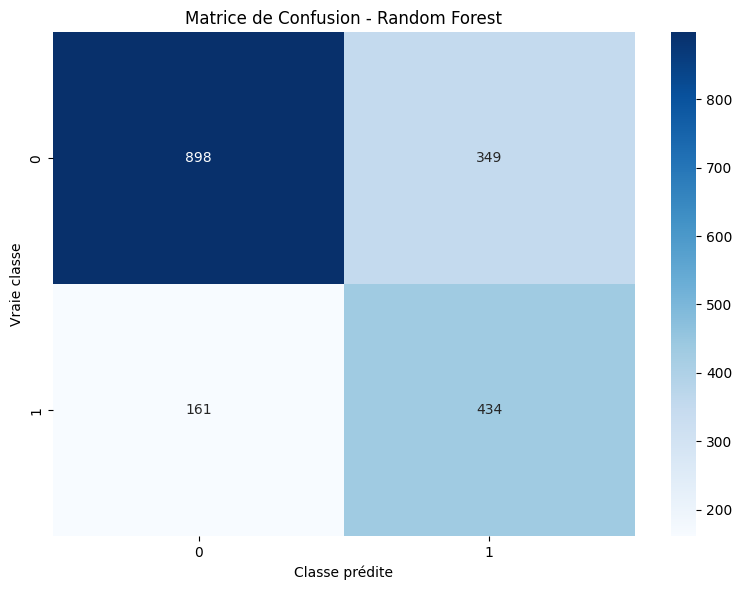

In [256]:
# ====================
# MODÈLE 1 : CLASSIFICATION (Y aura-t-il un retard ?)
# ====================

print("\n" + "="*20)
print("MODÈLE 1 : CLASSIFICATION - Détection de retard > 2 minutes")
print("="*20)

# Modèle 1 : Régression Logistique (simple, interprétable)
clf_logistic = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'))
])

# Modèle 2 : Random Forest (plus puissant)
clf_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        class_weight='balanced'
    ))
])

# Entraîner les deux
print("\nEntraînement Logistic Regression...")
clf_logistic.fit(X_train, y_class_train)
y_pred_log = clf_logistic.predict(X_test)
y_proba_log = clf_logistic.predict_proba(X_test)[:, 1]

print("Entraînement Random Forest...")
clf_rf.fit(X_train, y_class_train)
y_pred_rf = clf_rf.predict(X_test)
y_proba_rf = clf_rf.predict_proba(X_test)[:, 1]

# Évaluation
print("\n--- Logistic Regression ---")
print(classification_report(y_class_test, y_pred_log))
print(f"ROC-AUC : {roc_auc_score(y_class_test, y_proba_log):.3f}")

print("\n--- Random Forest ---")
print(classification_report(y_class_test, y_pred_rf))
print(f"ROC-AUC : {roc_auc_score(y_class_test, y_proba_rf):.3f}")

# Matrice de confusion pour le meilleur modèle (RF)
cm = confusion_matrix(y_class_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matrice de Confusion - Random Forest')
plt.ylabel('Vraie classe')
plt.xlabel('Classe prédite')
plt.tight_layout()


MODÈLE 2 : RÉGRESSION - Prédiction de l'ampleur du retard

Nombre d'exemples pour la régression :
  Train : 2378
  Test : 595

Entraînement Ridge Regression...
Entraînement Random Forest Regressor...

--- Ridge Regression ---
MAE : 65.73 secondes
RMSE : 83.87 secondes
R² : 0.082
MAE : 1.10 minutes

--- Random Forest Regressor ---
MAE : 57.77 secondes
RMSE : 77.20 secondes
R² : 0.222
MAE : 0.96 minutes

IMPORTANCE DES FEATURES


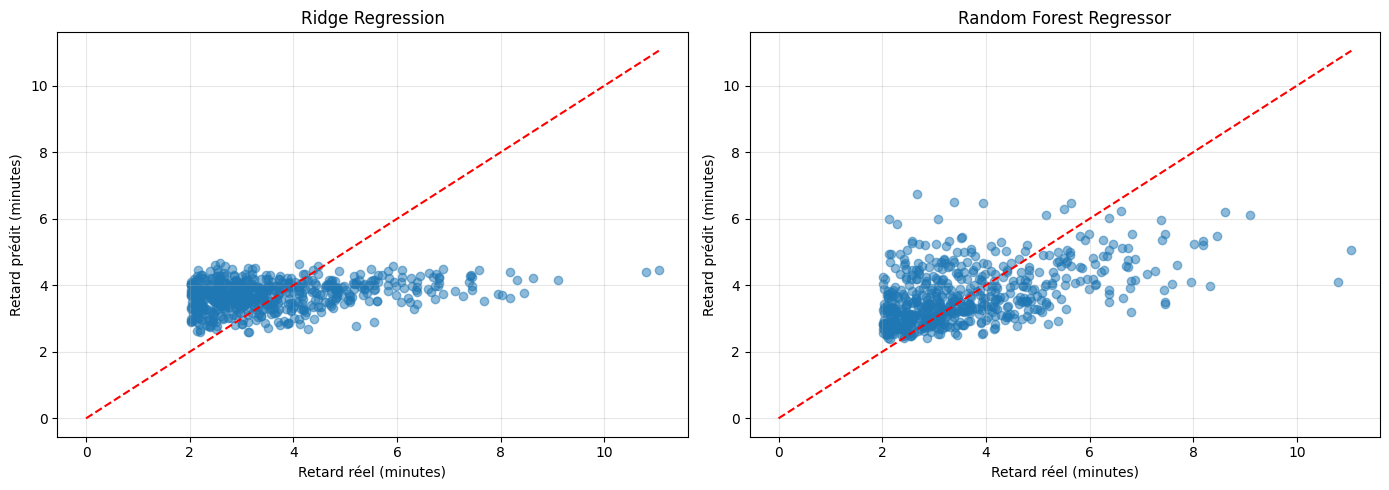

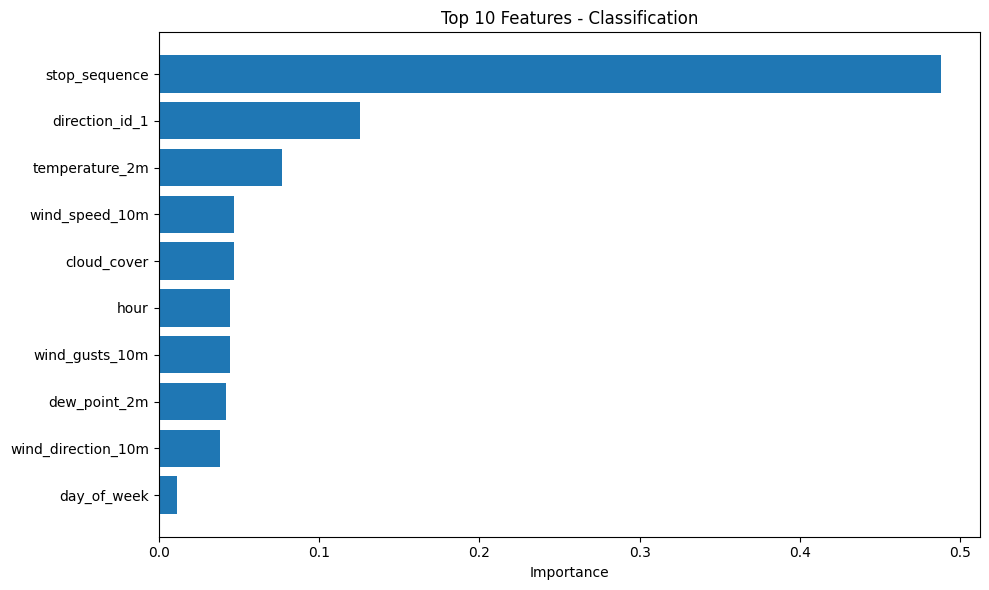

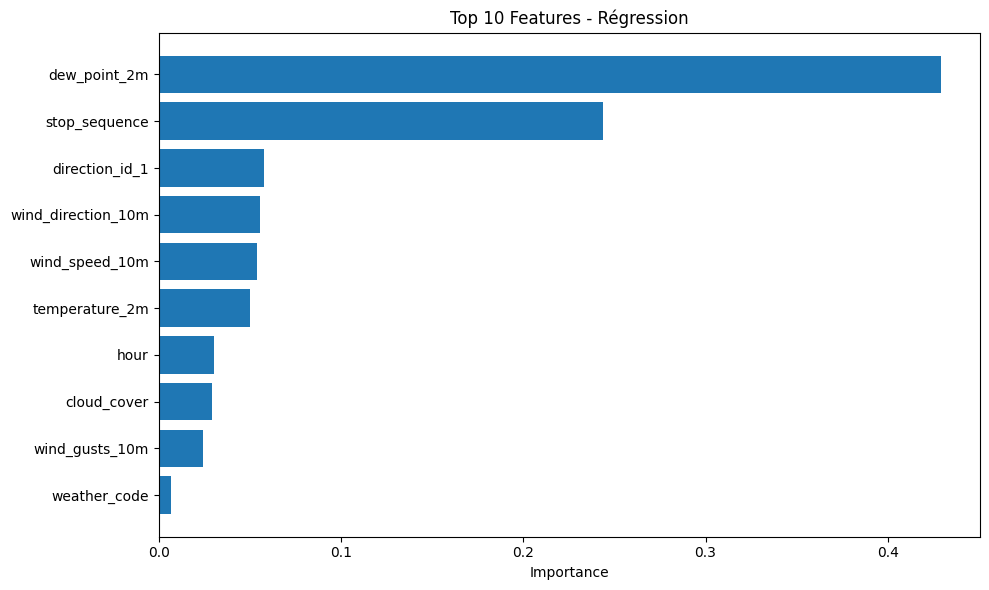

In [257]:
# ====================
# MODÈLE 2 : RÉGRESSION (De combien sera le retard ?)
# ====================

print("\n" + "="*20)
print("MODÈLE 2 : RÉGRESSION - Prédiction de l'ampleur du retard")
print("="*20)

# Filtrer uniquement les cas avec retard pour l'entraînement
mask_train_delayed = y_class_train == 1
mask_test_delayed = y_class_test == 1

X_train_delayed = X_train[mask_train_delayed]
y_reg_train_delayed = y_reg_train[mask_train_delayed]
X_test_delayed = X_test[mask_test_delayed]
y_reg_test_delayed = y_reg_test[mask_test_delayed]

print(f"\nNombre d'exemples pour la régression :")
print(f"  Train : {len(X_train_delayed)}")
print(f"  Test : {len(X_test_delayed)}")

# Modèle 1 : Ridge Regression
reg_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Modèle 2 : Random Forest Regressor
reg_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42
    ))
])

# Entraîner les deux
print("\nEntraînement Ridge Regression...")
reg_ridge.fit(X_train_delayed, y_reg_train_delayed)
y_pred_ridge = reg_ridge.predict(X_test_delayed)

print("Entraînement Random Forest Regressor...")
reg_rf.fit(X_train_delayed, y_reg_train_delayed)
y_pred_rf_reg = reg_rf.predict(X_test_delayed)

# Évaluation
def eval_regression(y_true, y_pred, model_name):
    print(f"\n--- {model_name} ---")
    print(f"MAE : {mean_absolute_error(y_true, y_pred):.2f} secondes")
    print(f"RMSE : {np.sqrt(mean_squared_error(y_true, y_pred)):.2f} secondes")
    print(f"R² : {r2_score(y_true, y_pred):.3f}")
    
    # Erreur en minutes
    mae_min = mean_absolute_error(y_true, y_pred) / 60
    print(f"MAE : {mae_min:.2f} minutes")

eval_regression(y_reg_test_delayed, y_pred_ridge, "Ridge Regression")
eval_regression(y_reg_test_delayed, y_pred_rf_reg, "Random Forest Regressor")

# Visualisation des prédictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].scatter(y_reg_test_delayed/60, y_pred_ridge/60, alpha=0.5)
axes[0].plot([0, y_reg_test_delayed.max()/60], [0, y_reg_test_delayed.max()/60], 'r--')
axes[0].set_xlabel('Retard réel (minutes)')
axes[0].set_ylabel('Retard prédit (minutes)')
axes[0].set_title('Ridge Regression')
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_reg_test_delayed/60, y_pred_rf_reg/60, alpha=0.5)
axes[1].plot([0, y_reg_test_delayed.max()/60], [0, y_reg_test_delayed.max()/60], 'r--')
axes[1].set_xlabel('Retard réel (minutes)')
axes[1].set_ylabel('Retard prédit (minutes)')
axes[1].set_title('Random Forest Regressor')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()

# ====================
# IMPORTANCE DES FEATURES (Random Forest)
# ====================

print("\n" + "="*20)
print("IMPORTANCE DES FEATURES")
print("="*20)

# Pour le classificateur
feature_names_transformed = (
    numeric_features + 
    list(clf_rf.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

importances_clf = clf_rf.named_steps['classifier'].feature_importances_
indices_clf = np.argsort(importances_clf)[-10:]  # Top 10

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_clf)), importances_clf[indices_clf])
plt.yticks(range(len(indices_clf)), [feature_names_transformed[i] for i in indices_clf])
plt.xlabel('Importance')
plt.title('Top 10 Features - Classification')
plt.tight_layout()

# Pour le régresseur
importances_reg = reg_rf.named_steps['regressor'].feature_importances_
indices_reg = np.argsort(importances_reg)[-10:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices_reg)), importances_reg[indices_reg])
plt.yticks(range(len(indices_reg)), [feature_names_transformed[i] for i in indices_reg])
plt.xlabel('Importance')
plt.title('Top 10 Features - Régression')
plt.tight_layout()

In [258]:
# ====================
# PRÉDICTION EN DEUX ÉTAPES
# ====================

print("\n" + "="*20)
print("EXEMPLE D'UTILISATION - Prédiction en 2 étapes")
print("="*20)

def predict_delay(model_clf, model_reg, X_new):
    """
    Prédit d'abord s'il y aura un retard, puis son ampleur
    """
    # Étape 1 : Classification
    proba_delay = model_clf.predict_proba(X_new)[:, 1]
    has_delay = model_clf.predict(X_new)
    
    # Étape 2 : Régression (seulement si retard prédit)
    delay_amount = np.zeros(len(X_new))
    mask_delayed = has_delay == 1
    
    if mask_delayed.sum() > 0:
        delay_amount[mask_delayed] = model_reg.predict(X_new[mask_delayed])
    
    return has_delay, proba_delay, delay_amount

# Test sur quelques exemples
sample_indices = np.random.choice(len(X_test), 5, replace=False)
X_sample = X_test.iloc[sample_indices]

has_delay, proba, amount = predict_delay(clf_rf, reg_rf, X_sample)

print("\nExemples de prédictions :")
for i, idx in enumerate(sample_indices):
    print(f"\nObservation {i+1}:")
    print(f"  Probabilité de retard : {proba[i]*100:.1f}%")
    if has_delay[i]:
        print(f"  Retard prédit : {amount[i]/60:.1f} minutes")
    else:
        print(f"  Pas de retard prévu")
    print(f"  Retard réel : {y_reg_test.iloc[idx]/60:.1f} minutes")

print("\n" + "="*20)
print("ANALYSE TERMINÉE")
print("="*20)


EXEMPLE D'UTILISATION - Prédiction en 2 étapes

Exemples de prédictions :

Observation 1:
  Probabilité de retard : 50.2%
  Retard prédit : 3.3 minutes
  Retard réel : 1.4 minutes

Observation 2:
  Probabilité de retard : 63.3%
  Retard prédit : 4.0 minutes
  Retard réel : 4.7 minutes

Observation 3:
  Probabilité de retard : 21.9%
  Pas de retard prévu
  Retard réel : 0.0 minutes

Observation 4:
  Probabilité de retard : 10.5%
  Pas de retard prévu
  Retard réel : -3.3 minutes

Observation 5:
  Probabilité de retard : 1.3%
  Pas de retard prévu
  Retard réel : 0.3 minutes

ANALYSE TERMINÉE
